Importamos librerías, y subimos el archivo data_process.csv

In [1]:
!pip install nltk

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

Cargo los datos

In [2]:
df = pd.read_csv('data_prepocess.csv')
df.shape

(5000, 9)

Reemplazo los "na" por espaios en blanco para asegurarme que no haya valores nulos

In [3]:
df['texto_limpio'].fillna('', inplace=True)

Separo los datos en train y test al 75% y 25% respectivamente

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df['texto_limpio'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [5]:
X_train.iloc[:10]

4884     very cute way give appreciated gift niece nephew
3163                         well described sent received
490     i called customer service gift card box presen...
862     i america nowtherefore buy ebooks via gift car...
1740    promotion buy fifty gift card receive fifteen ...
4099    perfect birthday anniversary wedding baby show...
4385                                  very easy customise
2447                           wish email delivery option
4230    i always reluctant online gift card option als...
506         maybe worst looking gift card i ever received
Name: texto_limpio, dtype: object

In [6]:
y_train.iloc[:10]

4884    0
3163    0
490     1
862     1
1740    1
4099    0
4385    0
2447    0
4230    0
506     1
Name: sentiment_label, dtype: int64

Realizo la extracción de características con un Tfidf, limitando a un máximo de 2500

In [7]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3, strip_accents='ascii')

Realizo una comprobación del vocabulario y del la longitud de este

In [8]:
print(list(cv.vocabulary_.items())[:20])

[('very', 1925), ('cute', 429), ('way', 1954), ('give', 762), ('appreciated', 112), ('gift', 754), ('niece', 1161), ('nephew', 1151), ('well', 1965), ('described', 473), ('sent', 1569), ('received', 1413), ('called', 257), ('customer', 426), ('service', 1577), ('card', 271), ('box', 223), ('presentable', 1331), ('unfortunately', 1885), ('cant', 268)]


In [9]:
print(len(cv.vocabulary_))

2038


Convierto el texto en vectores

In [10]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Verifico la etiqueta del sentimiento

In [11]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 338
Sentiment: 0
Review: i needed send gift card dozen client reward completing survey amazon system convenient it allowed enter multiple recipient time i liked i would send chunk one five recipient pace reward earned several week the downside session adding one five recipient i basically start scratch uploading sizing custom image logo retype paragraph text thankyou message wanted send card this product would better one could save uploaded customized version gift card template this would saved lot time


Ignoro las advertencias para ver más limpio el resultado del entrenamiento, ya que por una actualización lanza muchos avisos entre los distintos accuracy

In [12]:
import warnings
warnings.filterwarnings('ignore')

Paso al entrenamiento de un modelo de Regresión Logística con diferentes parámetros

In [13]:
c_params = [0.01, 0.2, 0.5, 0.8, 1, 1.2, 1.5, 1.8, 100, 1000]


train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.5936
Accuracy for C=0.2: 0.7504
Accuracy for C=0.5: 0.7768
Accuracy for C=0.8: 0.7832
Accuracy for C=1: 0.7864
Accuracy for C=1.2: 0.7872
Accuracy for C=1.5: 0.7848
Accuracy for C=1.8: 0.7848
Accuracy for C=100: 0.7296
Accuracy for C=1000: 0.716


In [16]:
optimal_C = 1.2

lr = LogisticRegression(C=optimal_C, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
test_predict = lr.predict(X_test_)

print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

train_acc.append(accuracy_score(y_train, train_predict))
test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=1000: 0.7872


Obtengo la matriz de confusión para ver las diferentes métricas del modelo

In [17]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[637 105]
 [161 347]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       742
           1       0.77      0.68      0.72       508

    accuracy                           0.79      1250
   macro avg       0.78      0.77      0.78      1250
weighted avg       0.79      0.79      0.78      1250

Accuracy score:0.7872


Observo la evolución del modelo conforme varía el valor de C, observando que mejora hasta que llega un nivel en el que se desploma el accuracy de test

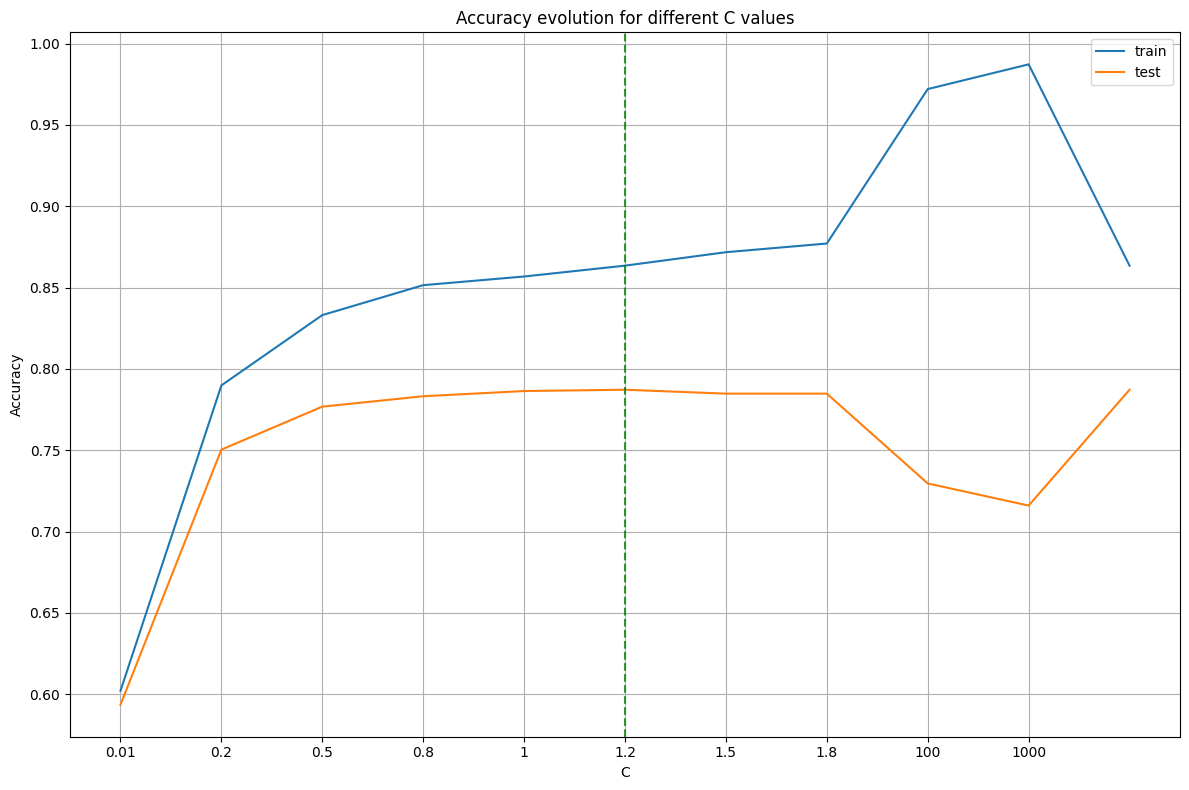

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Otra métrica que puedo analizar es ver la evolución de las puntuaciones de precisión y sensibilidad confome varía el umbral de decisión, en este caso puedo concluir por la gráfica que las predicciones del modelo son altamente precisas cuando predice un positivo

In [19]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

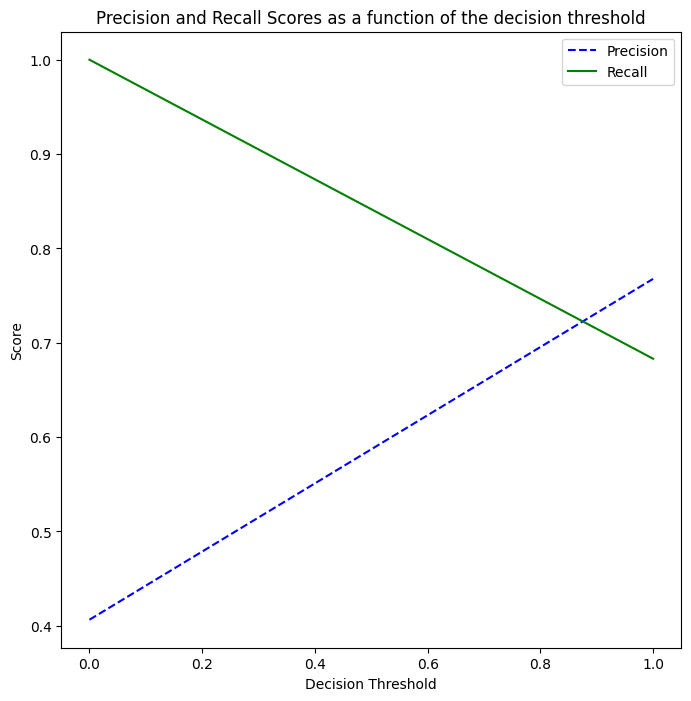

In [21]:
plot_precision_recall_vs_threshold(p, r, thresholds)

Ahora preparo otro modelo con XGBoost para comparar los resultados


In [22]:
from xgboost import XGBClassifier

# Creo las características usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['texto_limpio'])
y = df['sentiment_label']  # Columna con etiquetas de sentimiento (0 o 1)

# Divido de los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entreno el modelo XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Realizo predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Evaluo el rendimiento del modelo
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       594
           1       0.75      0.66      0.70       406

    accuracy                           0.77      1000
   macro avg       0.76      0.75      0.76      1000
weighted avg       0.77      0.77      0.77      1000

Accuracy: 0.77


como veo que el resultado es inferios al de regresión logistica y este lo había entrenado con diferentes hiperparámetros, paso a hacer una optimización de hiperparámetros en el modelo XGBoost

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 1, 1.2]
}

# Realizo la búsqueda en cuadrícula
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtengo los mejores hiperparámetros
best_params = grid_search.best_params_

# Entreno el modelo con los mejores hiperparámetros
best_xgb_model = XGBClassifier(**best_params)
best_xgb_model.fit(X_train, y_train)

# Realizo predicciones en el conjunto de prueba
y_pred = best_xgb_model.predict(X_test)

# Evaluo el rendimiento del modelo
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       594
           1       0.73      0.66      0.69       406

    accuracy                           0.76      1000
   macro avg       0.75      0.74      0.75      1000
weighted avg       0.76      0.76      0.76      1000

Accuracy: 0.76


Paso a exportar los modelos entrenados para poder utilizarlos a futuro

In [24]:
import joblib

modelo_entrenado =  xgb_model

joblib.dump(modelo_entrenado, 'modelo_entrenado.pkl')

modelo_entrenado_opt =best_xgb_model

joblib.dump(modelo_entrenado_opt, 'modelo_entrenado_opt.pkl')

['modelo_entrenado_opt.pkl']

Lo mismo con el modelo de regresión logistica

In [25]:
modelo_entrenado_lr =  lr

joblib.dump(modelo_entrenado_lr, 'modelo_entrenado_lr.pkl')

['modelo_entrenado_lr.pkl']

CONCLUSIONES FINALES

 Puedo observar que ofrece un mejor accuracy y f1-score el modelo de regresión logística que el de XGBoost. Y creo que tiene sentido en base a los datos, ya que el modelo de regresión logística ofrece mejores resultados con conjuntos de datos pequeños y balanceados, que es el caso, tenemos pocos datos y los he balanceado forzosamente por tanto las ventajas que podría ofrecer un XGBoost tanto en mejora de rendimiento, trato de datos desbalanceados, flexibilidad y regularización en este caso no suponen una ventaja.

 Observando las métricas del modelo de regresión logística, veo que validan la bondad del modelo ya con consigue unos valores razonablemente buenos. La evolución de las puntuaciones de precisión y sensibilidad confome varía el umbral de decisión muestra que el modelo es bastante preciso al predecir una valoración positiva, la evolución de la precisión confome aumento C me hace pensar que el modelo aprende correctamente hasta llegar al valor 1.8 donde creo que puede tener problemas de overfitting.  

 Con algo más de tiempo me habría gustado realizar un balaceado de datos más complejo y habría aplicado algún modelo de deeplearning, creo que el uso de una red neuronal habría mejorado la capacidad del modelo, y con más tiempo y recursos me gustaría aplicarlo a un conjunto de datos más compejos y ver los resultados.